In [1]:
#Imports.

import matplotlib.pyplot as plt
import numpy as np
import os.path
import refnx, scipy
from refnx.analysis import CurveFitter, Objective, Parameter, GlobalObjective, process_chain
from refnx.reflect import SLD, ReflectModel, Structure, LipidLeaflet
from refnx.dataset import ReflectDataset
import random
import tqdm
from solvFrac import monolayer

np.random.seed(1234)
%matplotlib inline

In [2]:
#Define all the neutron b's
bc = 0.6646e-4;	
bo = 0.5804e-4;	
bh = -0.3739e-4;
bp = 0.513e-4
bn = 0.936e-4
bd = 0.6671e-4

#Formulae of the molecule sections
CH2 = (1*bc) + (2*bh);
CH = (1*bc) + (1*bh);
CH3 = (1*bc) + (3*bh);
D2O = (2*bd) + (1*bo);
H2O = (2*bh) + (1*bo);

sum_b_tails = (28*CH2) + (2*CH) + (2*CH3) 
sum_popc_heads = (8*bo) + (1*bp) + (1*bn) + (2*bc) + (4*CH2) + (3*CH3) + (1*CH)
sum_popg_heads = (10*bo) + (1*bp) + (2*bc) + (4*CH2) + (2*CH) + (2*bh)
sum_b_heads = (1/4)*(3*(sum_popc_heads) + (sum_popg_heads)) 

vCH2 = 27.7
nCH2 = 30
vCH3 = 54.6
volume_tails = (nCH2 * vCH2) + (2 * vCH3)
volume_heads = 331

b_heads = Parameter(sum_b_heads, 'b_heads')
b_tails = Parameter(sum_b_tails, 'b_tails')

v_heads = Parameter(volume_heads, 'v_heads')
v_tails = Parameter(volume_tails, 'v_tails')

### Parameters

In [3]:
#Load in data. 

data_d2o = ReflectDataset('54696_97_d2o.txt')
data_pmw = ReflectDataset('54699_00_pmw.txt')

#Materials (Scattering Length Density)

d2o_sld = Parameter(6.2, 'd2o SLD', vary=True, bounds= (6,6.35))
pmw_sld = Parameter(2.2, 'pmw SLD', vary=True, bounds= (2,3))

d2o = SLD(d2o_sld) #D2O
pmw = SLD(pmw_sld) #PMW
air = SLD(0) #Air

#Structure
solvfrac = Parameter(0.65146, vary = True, name = 'solvent fraction', bounds = (0.6, 0.7))

apm = Parameter(60, 'area per molecule', vary=True, bounds=(55, 65))

head_thickness = Parameter(17.92, 'head_thickness', vary=True, bounds=(5.52, 20))
tail_thickness = Parameter(17.99, 'tail_thickness', vary=True, bounds=(15.67, 20.5))
roughness = Parameter(4, 'roughness', vary=True, bounds=(3.3, 10))

#D2O slab
d2o_slab = d2o(50, roughness)

#PMW slab
pmw_slab = pmw(50, roughness)

### Model

In [4]:

topD2O = monolayer(apm,
                    b_heads, v_heads, head_thickness,
                    b_tails, v_tails, tail_thickness,
                    roughness, solvfrac = solvfrac, head_solvent = 'd2o')


bottomD2O = monolayer(apm,
                    b_heads, v_heads, head_thickness,
                    b_tails, v_tails, tail_thickness, 
                    roughness, solvfrac = solvfrac, head_solvent = 'd2o', reverse_monolayer=True)

topPMW = monolayer(apm,
                    b_heads, v_heads, head_thickness,
                    b_tails, v_tails, tail_thickness,
                    roughness, solvfrac = solvfrac, head_solvent = 'pmw')


bottomPMW = monolayer(apm,
                    b_heads, v_heads, head_thickness,
                    b_tails, v_tails, tail_thickness, 
                    roughness, solvfrac = solvfrac, head_solvent = 'pmw', reverse_monolayer=True)

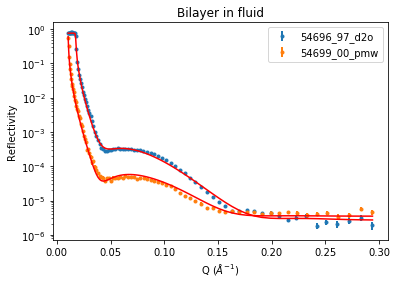

In [5]:
#Custom structure
structD2O = air | topD2O | bottomD2O | d2o_slab
structPMW = air | topPMW | bottomPMW | pmw_slab

scaleargs = dict(value = 0.7675, vary=False, bounds=(0.6, 0.8))
bkgargs = dict(value = 2.3e-6, vary=True, bounds=(1e-6, 5e-6))

modelD2O = ReflectModel(structD2O)
modelD2O.scale.setp(**scaleargs)
modelD2O.bkg.setp(**bkgargs)

modelPMW = ReflectModel(structPMW)
modelPMW.scale.setp(**scaleargs)
modelPMW.bkg.setp(**bkgargs)

objD2O = Objective(modelD2O, data_d2o)
objPMW = Objective(modelPMW, data_pmw)

globalObj = GlobalObjective([objD2O, objPMW])

fitCustom = CurveFitter(globalObj)
fitCustom.fit('differential_evolution')

globalObj.plot()
plt.title('Bilayer in fluid')
plt.yscale('log')
plt.xlabel('Q $(\AA^{-1})$')
plt.ylabel('Reflectivity')
plt.legend();

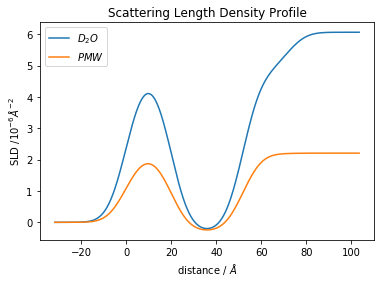

In [6]:
#SLD profile of structure.

plt.plot(*structD2O.sld_profile(), label = '$D_2O$')
plt.plot(*structPMW.sld_profile(), label = '$PMW$')
plt.title('Scattering Length Density Profile')
plt.ylabel('SLD /$10^{-6} \AA^{-2}$')
plt.xlabel('distance / $\AA$')
plt.legend();

In [7]:
print(globalObj.parameters)

________________________________________________________________________________
Parameters: 'global fitting parameters'
________________________________________________________________________________
Parameters:       ''       
________________________________________________________________________________
Parameters: 'instrument parameters'
<Parameter:    'scale'    , value=0.7675 (fixed)  , bounds=[0.6, 0.8]>
<Parameter:     'bkg'     , value=2.68812e-06 +/- 1.13e-07, bounds=[1e-06, 5e-06]>
<Parameter:'dq - resolution', value=5 (fixed)  , bounds=[-inf, inf]>
________________________________________________________________________________
Parameters: 'Structure - ' 
________________________________________________________________________________
Parameters:       ''       
<Parameter:  ' - thick'   , value=0 (fixed)  , bounds=[-inf, inf]>
<Parameter:   ' - sld'    , value=0 (fixed)  , bounds=[-inf, inf]>
<Parameter:   ' - isld'   , value=0 (fixed)  , bounds=[-inf, inf]>
<Parameter:

### MCMC 

In [8]:
#Burn frist 200, sample every 10th from 1000.

fitCustom.sample(1000)
process_chain(globalObj, fitCustom.chain, nburn=200, nthin=10, flatchain=True);

100%|██████████| 1000/1000 [09:12<00:00,  1.81it/s]


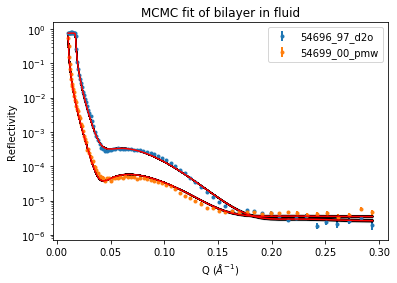

In [9]:
globalObj.plot(samples = 500)
plt.title('MCMC fit of bilayer in fluid')
plt.yscale('log')
plt.xlabel('Q $(\AA^{-1})$')
plt.ylabel('Reflectivity')
plt.legend();

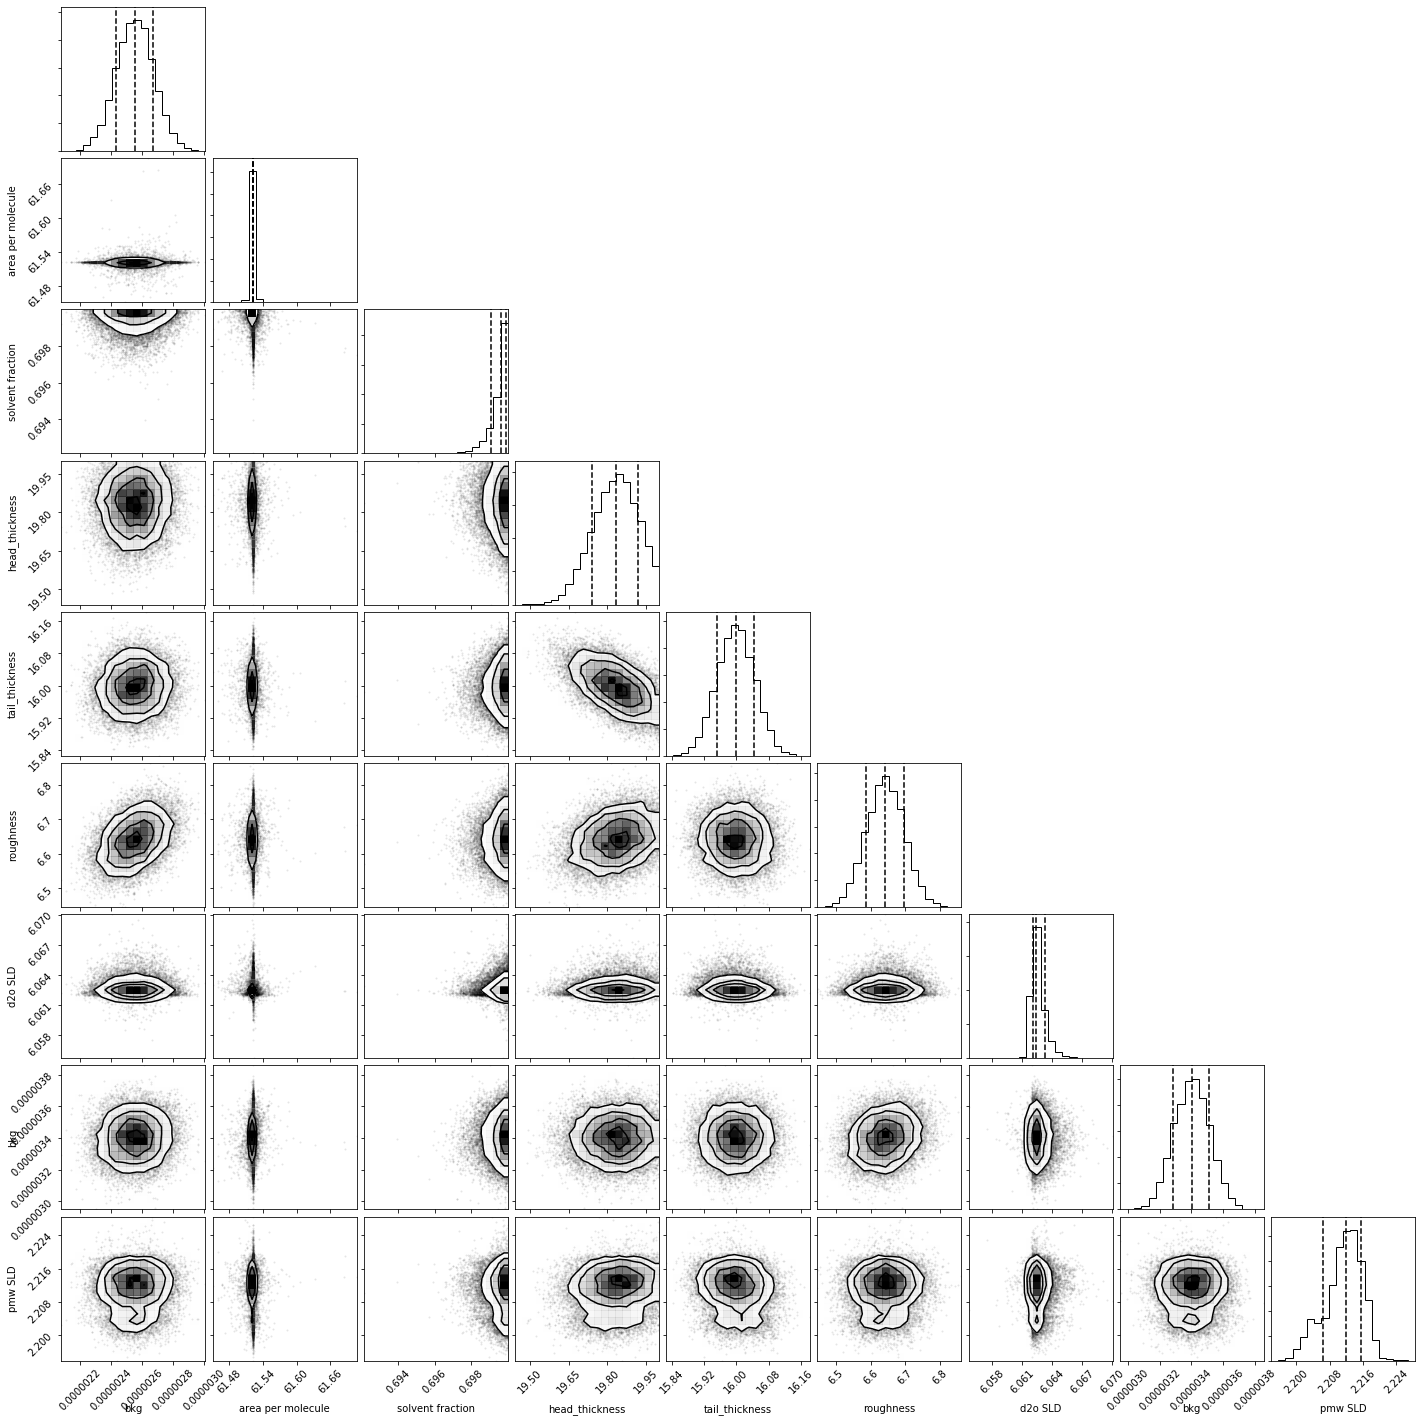

In [10]:
globalObj.corner();
#plt.savefig('cornerCustom.png');

In [11]:
print(globalObj.parameters)

________________________________________________________________________________
Parameters: 'global fitting parameters'
________________________________________________________________________________
Parameters:       ''       
________________________________________________________________________________
Parameters: 'instrument parameters'
<Parameter:    'scale'    , value=0.7675 (fixed)  , bounds=[0.6, 0.8]>
<Parameter:     'bkg'     , value=2.55099e-06 +/- 1.21e-07, bounds=[1e-06, 5e-06]>
<Parameter:'dq - resolution', value=5 (fixed)  , bounds=[-inf, inf]>
________________________________________________________________________________
Parameters: 'Structure - ' 
________________________________________________________________________________
Parameters:       ''       
<Parameter:  ' - thick'   , value=0 (fixed)  , bounds=[-inf, inf]>
<Parameter:   ' - sld'    , value=0 (fixed)  , bounds=[-inf, inf]>
<Parameter:   ' - isld'   , value=0 (fixed)  , bounds=[-inf, inf]>
<Parameter:

In [12]:
headThick = head_thickness.value
tailThick = tail_thickness.value

frac = 1 - ((tailThick*v_heads.value)/(v_tails.value*headThick))
Water = (frac*v_heads.value)/(29.9*(1 - frac))

print('Solvent fraction: {:.5f}\nWaters per head: {:.0f}'.format(frac, Water))

Solvent fraction: 0.71602
Waters per head: 28


In [13]:
frac = solvfrac.value
Water = (frac*v_heads.value)/(29.9*(1 - frac))

print('Solvent fraction (fit): {:.5f}\nWaters per head: {:.0f}'.format(frac, Water))

Solvent fraction (fit): 0.69966
Waters per head: 26
